In [1]:
#update libs
!pip install --upgrade pandas
!pip install --upgrade scikit-learn
!pip install --upgrade inflect
!pip install --upgrade pprint
!pip install --upgrade seaborn
!pip install --upgrade contractions
!pip install --upgrade wordcloud
!pip install --upgrade umap-learn
!pip install --upgrade gensim
!pip install --upgrade pyldavis
#!pip install pattern

Requirement already up-to-date: pandas in c:\anaconda\lib\site-packages (0.23.4)
Requirement already up-to-date: scikit-learn in c:\anaconda\lib\site-packages (0.20.2)
Requirement already up-to-date: inflect in c:\anaconda\lib\site-packages (2.1.0)
Requirement already up-to-date: pprint in c:\anaconda\lib\site-packages (0.1)
Requirement already up-to-date: seaborn in c:\anaconda\lib\site-packages (0.9.0)
Requirement already up-to-date: contractions in c:\anaconda\lib\site-packages (0.0.17)
Requirement already up-to-date: wordcloud in c:\anaconda\lib\site-packages (1.5.0)
Requirement already up-to-date: umap-learn in c:\anaconda\lib\site-packages (0.3.7)
Requirement already up-to-date: gensim in c:\anaconda\lib\site-packages (3.7.0)
Requirement already up-to-date: pyldavis in c:\anaconda\lib\site-packages (2.1.2)


In [2]:
#hdbscan test, not working import, what to do?
'''!pip install --upgrade PyHamcrest
!pip install --upgrade setuptools
!pip install --upgrade cython
!pip install --upgrade hdbscan
import setuptools
import cython
import hdbscan''';

In [3]:
#common libs
import numpy as np
import pandas as pd
import scipy.stats as st
from matplotlib import pyplot as plt
import seaborn as sns

import re
import string
import inflect
import itertools
from pprint import pprint
from tqdm import tqdm
import glob
import contractions
from wordcloud import WordCloud
import umap
import unicodedata
from bs4 import BeautifulSoup
from time import time
#import time

from itertools import compress
from collections import Counter

#from scipy import interp
sns.set(font_scale=1.3)

%matplotlib inline

In [4]:
#sklearn libs
from sklearn.preprocessing import label_binarize,MultiLabelBinarizer,StandardScaler
from sklearn.pipeline import make_pipeline,Pipeline

from sklearn.linear_model import LogisticRegression,SGDClassifier
from sklearn.svm import SVC,LinearSVC
from sklearn.naive_bayes import GaussianNB, MultinomialNB, BernoulliNB
from sklearn.cluster import KMeans,DBSCAN

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split 
from sklearn.model_selection import KFold,RandomizedSearchCV, cross_val_score

from sklearn.metrics import confusion_matrix, classification_report,f1_score
from sklearn.metrics import homogeneity_score,completeness_score, v_measure_score
from sklearn.metrics import adjusted_rand_score,adjusted_mutual_info_score,silhouette_score
from sklearn.manifold import TSNE

from sklearn.decomposition import TruncatedSVD

from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn.feature_extraction.stop_words import ENGLISH_STOP_WORDS

from gensim import matutils
from gensim.models.ldamodel import LdaModel
from gensim import corpora, models, similarities
from gensim.corpora.dictionary import Dictionary
#from gensim.utils import lemmatize as gensim_lemmatizer

import pyLDAvis
import pyLDAvis.sklearn
import pyLDAvis.gensim

#import pattern

In [5]:
#npl libs
import nltk
nltk.download('punkt')
nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('names')

from nltk.corpus import names
from nltk.corpus import stopwords
from nltk import ngrams

from nltk import word_tokenize
from nltk.stem.porter import PorterStemmer # one more stemmer? or lemmatisation
from nltk.stem import WordNetLemmatizer,LancasterStemmer

from sklearn.datasets import fetch_20newsgroups
seed = 321

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package names to
[nltk_data]     C:\Users\chief\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


Загрузим датасет с классифицируемыми текстами.

In [6]:
# здесь shuffle = true, т.к. мы собираемся использовать SGDClassifier; Naive Bayes - они базируются на принципе iid данных 
#и чтобы не получить смещенную оценку
newsgroups_all = fetch_20newsgroups(subset='all', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

Задача данной работы:
Классифицировать набор текстов из пакета sklearn по категориям верхнего уровня при помощи Naive Nayes, SVM, SGDClassifier.

Категории верхнего уровня: alt, comp, misc, rec, sci, soc, talk.

#### EDA.

Cам датасет представляет из себя набор различных текстов (приблизительно 20000) разделенных по 20 категориям.
Обучающие и тестовые части датасеты разделены во времени.

Ссылка на исходное описание датасета:
http://qwone.com/~jason/20Newsgroups/


Посмотрим на данные, для этого:
- посмотрим на категории текстов
- распределение документов по категориям
- посмотрим на примеры данных
- выделим топики верхнего уровня.

Здесь для обзорного исследования данных используем набор данных, который содержит в себе обучающую и тестовые выборки.

Чтобы не дублировать EDA, обзорно посмотрим на категории и количество текстов здесь и чуть более подробно во второй части работы.

In [7]:
pprint("%d documents" % len(newsgroups_all.data))
pprint("%d categories" % len(newsgroups_all.target_names))

'18846 documents'
'20 categories'


In [8]:
newsgroups_all.target_names

['alt.atheism',
 'comp.graphics',
 'comp.os.ms-windows.misc',
 'comp.sys.ibm.pc.hardware',
 'comp.sys.mac.hardware',
 'comp.windows.x',
 'misc.forsale',
 'rec.autos',
 'rec.motorcycles',
 'rec.sport.baseball',
 'rec.sport.hockey',
 'sci.crypt',
 'sci.electronics',
 'sci.med',
 'sci.space',
 'soc.religion.christian',
 'talk.politics.guns',
 'talk.politics.mideast',
 'talk.politics.misc',
 'talk.religion.misc']

In [9]:
def generate_stat_df(df,df_type):
    unique, counts = np.unique(df.target, return_counts=True)

    df_print = pd.DataFrame(data=list(zip(unique, df.target_names, counts)), 
                            columns = ['Id_category', 'Category_Name', 'N_texts'])
    df_print['High_level_topic'] = df_print["Category_Name"].str.split(".", expand = True)[0]
    df_print['Dataset_Type'] = df_type
    return df_print

df_summary = generate_stat_df(train_texts, 'train')
df_summary = df_summary.append(generate_stat_df(test_texts, 'test'), ignore_index=True)
df_summary = df_summary.append(generate_stat_df(newsgroups_all, 'all'), ignore_index=True)

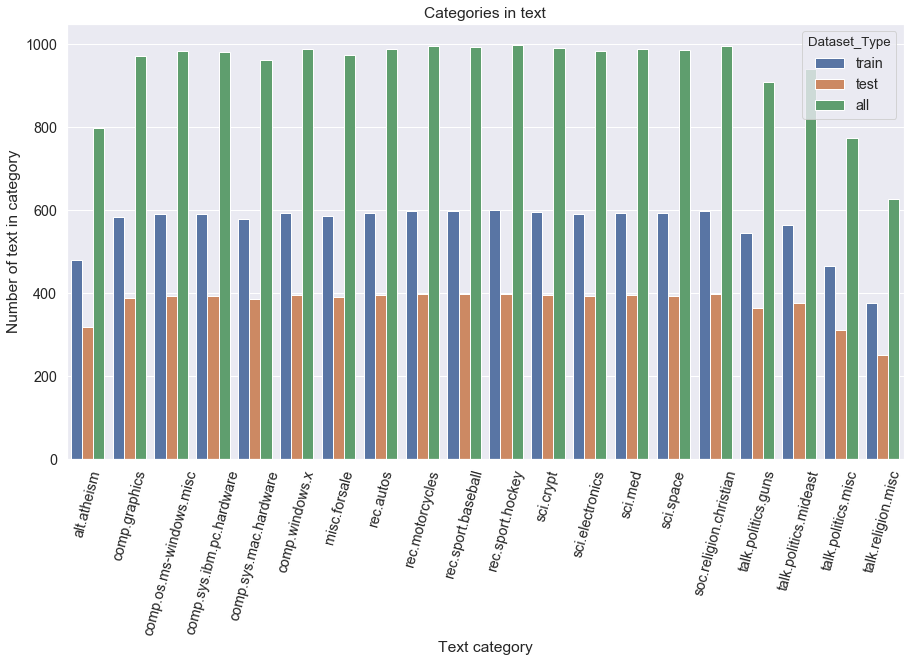

In [10]:
# print the histogramm with distribution of texts by categorieas and topics
plt.figure(figsize=(15,8))
sns.barplot(x="Category_Name", y="N_texts", hue = 'Dataset_Type',data=df_summary)
plt.xticks(rotation=75)
plt.xlabel('Text category');
plt.ylabel('Number of text in category');
plt.title("Categories in text");

Как видно, разделение данных на обучающей/тестовой выборке 60/40 и в среднем все категории содержат одникавое количество текстов.

Сгруппируем тексты по темам верхнего уровня и визуализируем.

                   0     1      2     3     4      5     6     7      8   \
High_level_topic  alt   alt    alt  comp  comp   comp  misc  misc   misc   
Dataset_Type      all  test  train   all  test  train   all  test  train   
N_texts           799   319    480  4891  1955   2936   975   390    585   

                    9   ...       11    12    13     14   15    16     17  \
High_level_topic   rec  ...      rec   sci   sci    sci  soc   soc    soc   
Dataset_Type       all  ...    train   all  test  train  all  test  train   
N_texts           3979  ...     2389  3952  1579   2373  997   398    599   

                    18    19     20  
High_level_topic  talk  talk   talk  
Dataset_Type       all  test  train  
N_texts           3253  1301   1952  

[3 rows x 21 columns]


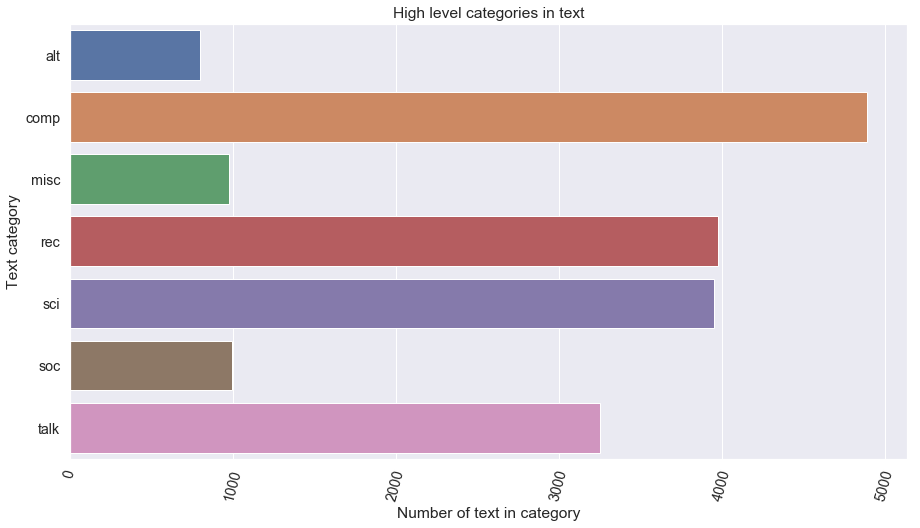

In [11]:
groupped_df = df_summary.groupby(['High_level_topic','Dataset_Type']).agg({'N_texts': ['sum']})
groupped_df.columns = groupped_df.columns.droplevel(1)
groupped_df.reset_index(inplace=True)
print(groupped_df.T)


plt.figure(figsize=(15,8))
sns.barplot(x="N_texts", y="High_level_topic", data=groupped_df[groupped_df.Dataset_Type == 'all'])
plt.xticks(rotation=75)
plt.xlabel('Number of text in category');
plt.ylabel('Text category');
plt.title("High level categories in text");

Как видно в некоторых категориях данных текстов немного по сравнению с остальными и темы, которые содержат в себе сразу несколько категорий значительно преобладают по количеству в них текстов.


Также не стоит забывать что в изначальном датасете некоторые категории текстов явно могут пересекаться. 

Например 'alt.atheism','talk.religion.misc' и 'soc.religion.christian'.

Посмотрим на образец данных.

In [12]:
pprint(newsgroups_all.data[11])

('\n'
 'This is a ridiculous argument for being a Christian.  So then, you might \n'
 'consider switching from Christianity to another religion if you were \n'
 'offered an even more frightening description of another hell?  How many\n'
 'Christians do think there are who view it strictly as an insurance policy?\n'
 'Not many I know; they believe in a message of love and compassion for \n'
 'others.  A faith based on fear of hell sounds like a dysfunctional \n'
 "relationship with God.  Like a child who cringes in fear of a parent's\n"
 'physical violence.  \n'
 '\n'
 'Many religions have concrete views of heaven and hell, with various\n'
 'threats and persuasions regarding who will go where.  Competition over\n'
 'who can envison the worst hell can hardly nurture the idea of loving\n'
 'your neighbor as yourself.\n'
 '\n')


In [13]:
newsgroups_all.target_names[newsgroups_all.target[11]]

'soc.religion.christian'

Текст содержит элементы вида - перенос строки, знаки препинания, имя собественное.

In [14]:
pprint(newsgroups_all.data[39])

('\n'
 '\n'
 "Again, you missed Jesus's point.  If you read the surrounding passages\n"
 'you would understand what Jesus means by "life in the world."  But\n'
 'as is, you bumbled around, asserted your standard axiom that the Bible is '
 'bunk,\n'
 'and came up with the wrong idea.  Also, you do not know exactly\n'
 'what Jesus means by eternal life.  \n'
 '\n'
 'Brian K., do you expect to jump in the middle of the quantum mechanics\n'
 'book and understand Hermite polynomials having not read the surrounding\n'
 'material?  Why do you such with the Bible?  For an idea what Jesus\n'
 'means by the world, look up references to it in your concordance.  For\n'
 'a good description, the whole Book of Ecclesiastes is game.  For \n'
 'eternal life, check out John 17:3, John 3:15-16.  You will find that\n'
 'eternal life is quite different than what you think.  Eternal life\n'
 'starts NOW--an infinitely high quality of life living in fellowship\n'
 'with God.\n'
 '\n'
 '\n'
 '\n'
 'If my die

In [15]:
newsgroups_all.target_names[newsgroups_all.target[39]]

'talk.religion.misc'

Помимо элементов из предыдущего текста здесь добавились ..., почтовый адрес и другие 'шумовые' элементы.

#### Data preprocessing.

Предобработаем данные, для этого:
- оставим только верхние категории текстов.

Созданим токенайзер, который будет:
- приведем все слова к нижнему регистру+.
- удалим знаки препинания+.
- отсечем стоп слова (уберем символы и комбинации, которые не составляют смысловой нагрузки)+.
- проведем лемматизацию/стемминг (приведение слова к начальной форме с помощью словаря/выделение корня слова)+.
- удалим слова длиной менее 2 символов+.
- выделим n-граммы (последовательности из нескольких слов, рассматриваемых как одно целое) (уже в TFIDF).

Также, в дополнение к остальным пробовал такой метод, но он не принес улучшения.
- заменим представление чисел в виде цифр на текстовые аналоги+.

In [16]:
#modifyied
def preprocess_categories(text):
    #unique, counts = np.unique(text.target, return_counts=True)
    df_texts = pd.DataFrame(data=list(zip(text.data, text.target)),columns = ['data','category'])
    #remake this into better code!
    for i in df_texts.index:
        df_texts.loc[i, 'category'] = newsgroups_all.target_names[df_texts.at[i, 'category']];
        
    df_texts['target'] = df_texts["category"].str.split(".", expand = True)[0]
    
    df_texts.drop('category',inplace = True, axis = 1)

    return df_texts

In [17]:
train_texts = fetch_20newsgroups(subset='train', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))
test_texts = fetch_20newsgroups(subset='test', random_state=seed, shuffle=True, remove = ('headers', 'footers', 'quotes'))

In [18]:
train_texts = preprocess_categories(train_texts);
test_texts = preprocess_categories(test_texts);

In [19]:
train_texts.shape

(11314, 2)

In [20]:
test_texts.shape

(7532, 2)

##### Tokenizer.

In [21]:
def remove_emails(text):
    text = re.sub(r'\S*@\S*\s?','',text)    
    return text


In [22]:
#version on raw text
def remove_punctuation2(text_punctuation,text):
    
    new_text = []
    new_text = re.sub('\n', ' ',text)
    new_text = re.sub('\t', '',new_text)
    new_text = re.sub('['+text_punctuation+']', ' ',new_text)
    new_text =  new_text.strip()
    
    return new_text

#version after word_tokenizer
def remove_punctuation(text_punctuation,text):
    
    new_text = []
    for word in text: 
        new_word =  re.sub('['+text_punctuation+']', ' ',word)
        new_word =  new_word.strip()
        new_text.append(new_word)
    
    return new_text

In [23]:
def digits_to_text(text):
    p = inflect.engine()
    new_text = []
    for word in text:
        if word.isdigit():
            new_word = p.number_to_words(word,group=2)
            new_text.append(new_word)
        else:
            new_text.append(word)

    return new_text

In [24]:
#gensim word lemmatizer
def lemmatize_stemm_text2(text):
    new_text_lemma = []
    for wd in gensim_lemmatizer(str(text)):
        new_text_lemma.append(wd.decode('utf-8').split('/')[0])
        
    return new_text_lemma, _

In [25]:
#ntlk word lemmatizer
def lemmatize_stemm_text(text):
    new_text_lemma = []
    new_text_stemm = []
    
    lemmatizer = WordNetLemmatizer()
    stemmer = LancasterStemmer()
    
    for word in text:
        lemma = lemmatizer.lemmatize(word, pos='n') # v default
        new_text_lemma.append(lemma)
        
        #stemm = stemmer.stem(word)
        #new_text_stemm.append(stemm)
        
    return new_text_lemma, new_text_stemm
        

По ходу работы расширяем набор стоп слов при помощи TF-IDF.

А также используем объединненый словарик из стоп слов NTLK + Sklearn(frozen set) + NTLK names words set.

In [26]:
StopWords = list(set( stopwords.words('english') ).union( set(ENGLISH_STOP_WORDS)))
newStopWords = ['jfc','jb'] # по ходу работы периодически добавляем стоп-слова
newStopWords2 = ['arent', 'didnt', 'doesnt', 'dont', 'hadnt', 'havent', 'isnt', 
                 'mightnt', 'mustnt', 'neednt', 'shant', 'shes', 'shouldnt', 'shouldve', 'theres','thatll', 'wasnt', 
                 'werent', 'wont', 'wouldnt', 'youd', 'youll', 'youre', 'youve',
                 "'ll", "'re", "'ve", "n't", 'need', 'sha', 'anna','n t','ann mari', 'ann marie', 
                 'anna diana', 'anna diane', 'anna maria', 'anne corinne', 'anne mar', 'anne marie', 
                 'barbara anne', 'bette ann', 'carol jean', 'diane marie', 'e lane', 'hans peter', 
                 'helen elizabeth', 'holly anne', 'jean christophe', 'jean francois', 'jean lou', 
                 'jean luc', 'jean marc', 'jean paul', 'jean pierre', 'jo anne', 'john david', 'john patrick', 
                 'kara lynn', 'marie ann', 'marie jeanne', 'paula grace', 'sara ann', 
                 'sheila kathryn', 'sue elle', 'terri jo', 'theresa marie','sza']

StopWords.extend(newStopWords)
StopWords.extend(newStopWords2)


male_names = names.words('male.txt')
female_names = names.words('female.txt')

Common_First_Names = list(set(male_names).union(set(female_names)))
Common_First_Names = list(map(lambda word: word.lower(), Common_First_Names))
# temporaly disabled to reduce tfidf time
#StopWords.extend(Common_First_Names) 

def remove_stopwords(stop_words ,text):
    
    new_words = []
    for word in text:
        if word not in stop_words:
            new_words.append(word)

    return new_words

In [27]:
def remove_short_words(text, word_len):
    new_text = []
    for word in text:
        if len(word) >= word_len:
            new_text.append(word)
            
    return new_text

Также добавим несколько мини функций для удаления html конструкции,  исправления  contractions (в английском языке - перевод n't -> not) и удалим ascii символы.

In [28]:
#replace contractions in string of text
def replace_contractions(text):
    return contractions.fix(text)

In [29]:
#remove html constructions
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

In [30]:
#remove non-ASCII characters from list of tokenized words
def remove_non_ascii(words):

    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

In [31]:
# getting source from string.punctuation
text_punctuation = '!"#$%&\'()*+,-.:;<=>?@[\\]_`{|}~/^'

def tokenize(text):
    min_length = 3
    
    # remove emails from text to prevent overfit
    text = remove_emails(text)
    
    #remove html 
    text = strip_html(text)
    
    # text to lowercase
    text =  text.lower()
    
    # test it
    text = replace_contractions(text)
    
    #remove punctuation
    text = remove_punctuation2(text_punctuation, text) 

    # tokenize text
    words = word_tokenize(text,language='english')
    
    #remove non ascii? test it
    words = remove_non_ascii(words)
    
    #replace digits with words
    #words = digits_to_text(words)
        
    # remove stopwords
    words = remove_stopwords(StopWords,words)
    
    #lemmatize words ,improve to 0.69 f1score
    words,_ = lemmatize_stemm_text(words)
    
    #filter short words
    words = remove_short_words(words, 2) #default 3

    return words

Протестируем работу полученной функции.

In [32]:
%%time
test = tokenize(test_texts.data[4])

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 26.9 ms


In [33]:
test

[]

Похоже, часть текста после отсечения стоп слов и очистки текстов может обнулиться. Это следует учесть при извлечении фич из текста.

Проверим работу токенайзера на других текстах.

In [34]:
pprint(newsgroups_all.data[10:15]) #1,3,55,39

['From: Center for Policy Research <cpr>\n'
 'Subject: Zionism - racism\n'
 '\n'
 '\n'
 "Diaspora 'a cancer'\n"
 '------------------- by Julian Kossoff and Lindsay Schusman in:\n'
 'Jewish Chronicle, London, 22. Dec. 1989\n'
 '\n'
 'Leading Israeli author and cultural commentator, A.B. Yehoshua,\n'
 'launched a ferocious attack on diaspora Jewry at a Zionist Youth\n'
 'Council meeting in North London, last week.\n'
 '\n'
 'The diaspora, he claimed, "was the cancer connected to the main\n'
 'tissue of the Jewish people". He was scathing about its failure to\n'
 'act before the Holocaust.\n'
 '\n'
 "He said the diaspora's religious and secular leadership had\n"
 'ignored the warning signs in the 1920s, and had fiercely opposed\n'
 'Zionism. Consequently, he considered the Holocaust, "the failure\n'
 'of Judaism".\n'
 '\n'
 'His talk, entitled "Diaspora: A Neurotic Solution", covered 5,000\n'
 'years of Jewish history.\n'
 '\n'
 "Mr. Yehoshua's other targets included Soviet Jews who were,

In [35]:
test0 = tokenize(newsgroups_all.data[1])
test = tokenize(newsgroups_all.data[10])
test2 = tokenize(newsgroups_all.data[13])
test4 = tokenize(newsgroups_all.data[44])
test5 = tokenize(newsgroups_all.data[55])
test6 = tokenize(newsgroups_all.data[66])

In [36]:
test0,test,test2, test4, test6, test5

(['gamma',
  'ray',
  'burster',
  'extragalactic',
  'absorption',
  'galaxy',
  'expected',
  'transparent',
  'galactic',
  'core',
  'gamma',
  'ray',
  'later',
  'law',
  'incorrect',
  'assume',
  'unknown',
  'material',
  'dark',
  'matter',
  'inhibits',
  'gamma',
  'ray',
  'propagation',
  'possible',
  'actually',
  'seeing',
  'energetic',
  'event',
  'happening',
  'closer',
  'distribution',
  'caused',
  'characteristic',
  'propagation',
  'distance',
  'gamma',
  'ray',
  'shorter',
  'thickness',
  'disk',
  'galaxy',
  'maybe',
  'zero',
  'little',
  'typical',
  'energy',
  'gamma',
  'ray',
  'galaxy',
  'effectively',
  'transparent',
  'han',
  'bloemen',
  'review',
  'article',
  'ann',
  'rev',
  'astr',
  'astrophys',
  'year',
  'discus',
  'depth'],
 ['center',
  'policy',
  'research',
  'subject',
  'zionism',
  'racism',
  'diaspora',
  'cancer',
  'julian',
  'kossoff',
  'lindsay',
  'schusman',
  'jewish',
  'chronicle',
  'london',
  '22',
  'de

#### Classification. Apriory knoweledge.

После того, как проверили работу токенизатора, извлечем фичи из текста с использованием TF-IDF.

In [37]:
vectorizer = TfidfVectorizer(stop_words=StopWords,
                             tokenizer=tokenize, 
                             min_df=4, # ignore terms with freq less that т, lower majoring 4
                             max_df=0.8, # ignore terms with freq more that n, upper majoring 0.8
                             #max_features=100000,
                             use_idf=True,  
                             sublinear_tf=True,
                             norm='l2',
                             ngram_range= (1, 3) # также используем н-граммы
                            )

In [38]:
vectorised_train_documents = vectorizer.fit_transform(train_texts.data)
vectorised_test_documents = vectorizer.transform(test_texts.data)

C:\Anaconda\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ann', 'anne', 'barbara', 'bette', 'carol', 'christophe', 'corinne', 'david', 'diana', 'diane', 'elizabeth', 'elle', 'francois', 'grace', 'han', 'helen', 'holly', 'jean', 'jeanne', 'jo', 'john', 'kara', 'kathryn', 'lane', 'lou', 'luc', 'lynn', 'mar', 'marc', 'mari', 'maria', 'marie', 'patrick', 'paul', 'paula', 'peter', 'pierre', 'sara', 'shall', 'sheila', 'sue', 'terri', 'theresa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
C:\Anaconda\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and p

В силу того, что после извлечения фич могут получиться пустые тексты (например из-за отсечения стоп слов, по длине слова и т.д.), то есть смысл эти строки отфильтровать, чтобы улучшить качество классификации.

In [39]:
def get_empty_rows(sprs_matrix):
    #list_ind = []
    empty_indecies_marker = sprs_matrix.getnnz(1)>0
    '''for i in range(len(empty_indecies_marker)):
        if empty_indecies_marker[i] == False:
            list_ind.append(i)'''
    
    return empty_indecies_marker

Также не стоит забывать про обновление массивов с метками классов, для этого сохраним их индексы.

In [40]:
ind_train_to_drop = get_empty_rows(vectorised_train_documents)
ind_test_to_drop = get_empty_rows(vectorised_test_documents)

In [41]:
vectorised_train_documents.shape #before

(11314, 39571)

In [42]:
vectorised_test_documents.shape #before

(7532, 39571)

In [43]:
#vectorised_test_documents.sum(axis=1)
vectorised_train_documents = vectorised_train_documents[vectorised_train_documents.getnnz(1)>0]
vectorised_test_documents = vectorised_test_documents[vectorised_test_documents.getnnz(1)>0]

In [44]:
vectorised_train_documents.shape #after!

(10977, 39571)

In [45]:
vectorised_test_documents.shape #after!

(7290, 39571)

In [46]:
len(vectorizer.get_feature_names())

39571

Как видно, такие строки были и не в единичном количестве.

Выделим метки для трейн/тест датасетов.

In [47]:
y_train, y_test = train_texts.target, test_texts.target

In [48]:
len(y_train)

11314

In [49]:
len(y_test)

7532

Обновим метки классов, после удаления пустых строк, оставшихся после векторизации.

In [50]:
#y_train
y_train = list(compress(y_train, ind_train_to_drop))
y_test = list(compress(y_test, ind_test_to_drop))

In [51]:
len(y_train)

10977

In [52]:
len(y_test)

7290

Также используем несколько вспомогательных функций, которые будет производить:
- построение матрицы классификации.
- обучение и проверку работы классификатора, с заданными параметрами.

In [88]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Paired):

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [86]:
#simple variant
def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    clf = classifier
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='weighted')

    #print ("Test score")
    pred_test = clf.predict(X_test)
    f1_test = f1_score(y_test, pred_test, average='weighted')
    
    return f1_train, f1_test, clf

Для удобства, результирующие метрики будем сохранять сразу в датасет.

In [130]:
results_df = []
results_df = pd.DataFrame(columns=('Algorithm', 'Train_score', 'Test_score', 'parameters'))

Для корректного подбора параметров работы алгоритмов и кроссвалидации была написана более сложная функция с пайплайном и cross_val_score, но от нее пришлось отказаться, т.к. это занимает достаточно много времени.

Интересной особенностью, также оказалось то, что словарь tfidf надо строить отдельно на каждом разбиении, чтобы избежать переобучения.

In [131]:
#variant with pipeline and cv
#takes a long time
'''def classify_and_score(classifier, X_train, X_test, y_train, y_test):
    tfidf_params = {
        'stop_words' : StopWords,
        'tokenizer':tokenize,
        'use_idf':True,
        'sublinear_tf':True,
        'norm':'l2'
    }
    clf = Pipeline([('vect', TfidfVectorizer(** tfidf_params)), ('classifier', classifier)])
    
    clf.fit(X_train, y_train)

    pred_train = clf.predict(X_train)
    #print ("Train score")
    f1_train = f1_score(y_train, pred_train, average='micro')

    #print ("Test score")
    #pred_test = clf.predict(X_test)
    #f1_test = f1_score(y_test, pred_test, average='micro')
    
    my_scorer = make_scorer(f1_score, average='weighted')
    skv = StratifiedKFold(n_splits = 3,random_state=seed, shuffle=True)
    f1_test = cross_val_score(clf, X_test, y_test, cv=skv, scoring=my_scorer,n_jobs = -1).mean()
    
    return f1_train, f1_test


alphas = [0.01 , 0.015, 0.02]

for alph in tqdm(alphas):
    a = "MultinomialNB"
    b,c = classify_and_score(MultinomialNB(alpha=alph), train_texts.data, 
                           test_texts.data, y_train, y_test)
    d = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':a, 'Train_score':b,'Test_score':c, 'parameters':d},ignore_index=True)
    
    ''';

Baseline model.

Logistic Regression.

In [132]:
log_reg = LogisticRegression(penalty='l2', tol=0.0001, C=1.0, 
                             class_weight='balanced', random_state=seed, 
                             max_iter=1000, solver = 'newton-cg',
                             multi_class='ovr', verbose=0, 
                             n_jobs=-1)

C =  [0.01, 0.05, 0.1, 0.5, 1, 4, 5, 6, 7, 10, 20, 40, 50]

In [133]:
for c in tqdm(C):
    f_el = "Logistic_Regression"
    log_reg.C = c
    s_el,t_el,_ = classify_and_score(log_reg, vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|██████████████████████████████████████████████████████████████████████████████████| 13/13 [00:24<00:00,  2.19s/it]


In [135]:
print(
results_df.iloc[results_df[results_df.Algorithm =='Logistic_Regression']['Test_score'].idxmax()]
)

Algorithm      Logistic_Regression
Train_score                0.99101
Test_score                0.817554
parameters                   C = 5
Name: 6, dtype: object


Проверим работу алгоритмов:
- MultinomialNB

In [369]:
#actual block of code
alphas = [0.0001,0.001,0.005 ,0.01 , 0.015, 0.02 , 0.025, 0.03 , 0.035, 0.04 , 0.045, 0.05 ,
       0.055, 0.06 , 0.065, 0.07 , 0.075, 0.08 , 0.085, 0.09 , 0.095,
       0.1  , 0.105, 0.11 , 0.115, 0.12 , 0.125, 0.13 , 0.135, 0.14 ,
       0.145, 0.15 , 0.155, 0.16 , 0.165, 0.17 , 0.175, 0.18 , 0.185,
       0.19 , 0.195, 0.31, 0.41, 0.51, 0.61, 0.71, 0.81, 0.91, 1.01, 2, 5]
 
for alph in tqdm(alphas):
    f_el = "MultinomialNB"
    s_el,t_el,_ = classify_and_score(MultinomialNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

 94%|███████████████████████████████████████▌  | 48/51 [00:02<00:00, 19.58it/s]D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 98%|█████████████████████████████████████████▏| 50/51 [00:02<00:00, 19.53it/s]D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
100%|██████████████████████████████████████████| 51/51 [00:02<00:00, 19.03it/s]


- BernoulliNB и GaussianNB в ходе работы были опробованы, но не использовались, т.к. BernoulliNB стабильно показывал результаты хуже чем MultionomialNB на 0.1-0.2 по f1-метрике.

А GaussianNB на вход требуется dense, а не sparce-матрица. При выполнении преобразования todense()/toarray() потребление памяти существенно возрастает и приводит к тому, что массив не помещяется в память.

- LinearSVC

In [84]:
linear_svc = LinearSVC(random_state=seed,max_iter = 10e3,class_weight = 'balanced',loss = 'squared_hinge',dual=False)
C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.9, 1.0, 2.0, 5.0, 10.0]
penalties = ['l2']#,'l1']

for pn in tqdm(penalties):
    linear_svc.penalty  = pn
    for c in tqdm(C_values):
        f_el = "LinearSVC"
        linear_svc.C = c
        s_el,t_el,_ = classify_and_score(linear_svc, vectorised_train_documents, 
                               vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " penalty = " + pn

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

NameError: name 'classify_and_score' is not defined

- SVC Kernel Poly,Sigmoid,RBF

Т.к. метод опорных векторов чувствителен к выбору ядра и их параметров и требует достаточно большое время на выполнение, то
обзорно запустим алгоритмы, и если они не покажут каких-либо улучшений по метрике, то перейдем далее к SGD.

In [372]:

svc_poly = SVC(kernel='poly',gamma='scale',random_state=seed,class_weight = 'balanced')

svc_poly.C = 0.5
svc_poly.kernel = 'poly'
f_el = "SVC_" + svc_poly.kernel
s_el,t_el,_ = classify_and_score(svc_poly,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_poly.C) + " Kernel = " + svc_poly.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)


svc_k = SVC(kernel='sigmoid',gamma='scale',random_state=seed,class_weight = 'balanced',verbose=True)

svc_k.C = 0.5
svc_k.kernel = 'sigmoid'
f_el = "SVC_" + svc_k.kernel
s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_k.C) + " Kernel = " + svc_k.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)


svc_k.C = 0.5
svc_k.kernel = 'rbf'
f_el = "SVC_" + svc_k.kernel
s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
f0_el = "C = " + str(svc_k.C) + " Kernel = " + svc_k.kernel

results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

In [373]:
results_df.tail(n=3)

,Algorithm,Train_score,Test_score,parameters
61,LinearSVC,0.998633,0.801818,C = 2.0 penalty = l2
62,LinearSVC,0.999089,0.791916,C = 5.0 penalty = l2
63,LinearSVC,0.999089,0.789182,C = 10.0 penalty = l2


Как видно, в случае классфикации текстов - метод опорных векторов работает не лучшим образом.

- SGDClassifier.

In [374]:
sgd_clf = SGDClassifier(loss = 'modified_huber', penalty = 'l2',
                        alpha = 0.0001, l1_ratio = 0.01,
                        max_iter = 1000, tol = 1e-4,
                        n_jobs = -1, random_state = seed,
                        learning_rate = 'optimal', #adaptive - no profit
                        class_weight = 'balanced', shuffle = True,
                        n_iter_no_change = 100, early_stopping = True
             )

In [375]:
losses = ['hinge','log','modified_huber','squared_hinge','perceptron']
penalties = ['l1','l2','elasticnet']
alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5]

for ls in tqdm(losses):
    f_el = "SGD"
    sgd_clf.loss = ls
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "loss = " + ls
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|████████████████████████████████████████████| 5/5 [00:04<00:00,  1.11it/s]


In [376]:
results_df.tail(n=5)

,Algorithm,Train_score,Test_score,parameters
64,SGD,0.971854,0.803668,loss = hinge
65,SGD,0.931096,0.803514,loss = log
66,SGD,0.983583,0.801726,loss = modified_huber
67,SGD,0.902058,0.746908,loss = squared_hinge
68,SGD,0.978818,0.756324,loss = perceptron


Как видно из результатов, лучше всего работает функция потерь:

In [377]:
sgd_clf.loss = 'modified_huber'
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=100, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=321, shuffle=True,
       tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

Попробуем подобрать для нее оптимальный параметр регуляризации:

In [378]:
for alp in tqdm(alphas):
    sgd_clf.alpha = alp
    f_el = "SGD"
    s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents,
                                     vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alp)
    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

 50%|██████████████████████                      | 4/8 [00:03<00:03,  1.01it/s]D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
 62%|███████████████████████████▌                | 5/8 [00:04<00:02,  1.02it/s]D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
D:\Programs\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.

In [379]:
results_df.tail(n=9)

,Algorithm,Train_score,Test_score,parameters
68,SGD,0.978818,0.756324,loss = perceptron
69,SGD,0.983583,0.801726,alpha = 0.0001
70,SGD,0.936496,0.804894,alpha = 0.001
71,SGD,0.859040,0.771991,alpha = 0.01
72,SGD,0.635609,0.585820,alpha = 0.1
73,SGD,0.304942,0.282785,alpha = 0.5
74,SGD,0.284809,0.279720,alpha = 1
75,SGD,0.072024,0.072279,alpha = 3
76,SGD,0.072024,0.072279,alpha = 5


Возвращаем обратно параметр alpha.

In [380]:
sgd_clf.alpha = 0.0001
sgd_clf

SGDClassifier(alpha=0.0001, average=False, class_weight='balanced',
       early_stopping=True, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.01, learning_rate='optimal', loss='modified_huber',
       max_iter=1000, n_iter=None, n_iter_no_change=100, n_jobs=-1,
       penalty='l2', power_t=0.5, random_state=321, shuffle=True,
       tol=0.0001, validation_fraction=0.1, verbose=0, warm_start=False)

In [381]:
def get_top_n_words(clf, vectorizer, n):
    # improve for most not used words too
    for cls in range(len(clf.coef_)):
        print (cls, labels[cls])
        neg_class_prob_sorted = clf.coef_[cls, :].argsort()[::1] #1 ascending order #-1 descending order
        pos_class_prob_sorted = clf.coef_[cls, :].argsort()[::-1] 
        print ("most informative features")
        print(np.take(vectorizer.get_feature_names(), pos_class_prob_sorted[:n]))
        print ("less informative features")
        print(np.take(vectorizer.get_feature_names(), neg_class_prob_sorted[:n]))

Выведем 3 алгоритма с наилучшими результатами.

In [382]:
print(
results_df.iloc[results_df[results_df.Algorithm =='Logistic_Regression']['Test_score'].idxmax(),'\n',
results_df.iloc[results_df[results_df.Algorithm =='MultinomialNB']['Test_score'].idxmax()],'\n',
results_df.iloc[results_df[results_df.Algorithm =='LinearSVC']['Test_score'].idxmax()],'\n',
results_df.iloc[results_df[results_df.Algorithm =='SGD']['Test_score'].idxmax()]
)

Algorithm      MultinomialNB
Train_score         0.965124
Test_score          0.809571
parameters     alpha = 0.025
Name: 6, dtype: object 
 Algorithm                 LinearSVC
Train_score                0.986528
Test_score                 0.809079
parameters     C = 0.4 penalty = l2
Name: 56, dtype: object 
 Algorithm                SGD
Train_score         0.936496
Test_score          0.804894
parameters     alpha = 0.001
Name: 70, dtype: object


Выведем матрицу классификации и топ слова для для алгоритма с наилучшим скором.

              precision    recall  f1-score   support

         alt       0.75      0.37      0.49       310
        comp       0.86      0.91      0.88      1906
        misc       0.87      0.68      0.76       382
         rec       0.88      0.89      0.89      1523
         sci       0.81      0.77      0.79      1518
         soc       0.72      0.78      0.75       384
        talk       0.74      0.82      0.78      1267

   micro avg       0.82      0.82      0.82      7290
   macro avg       0.80      0.75      0.76      7290
weighted avg       0.82      0.82      0.82      7290

Confusion matrix, without normalization
None


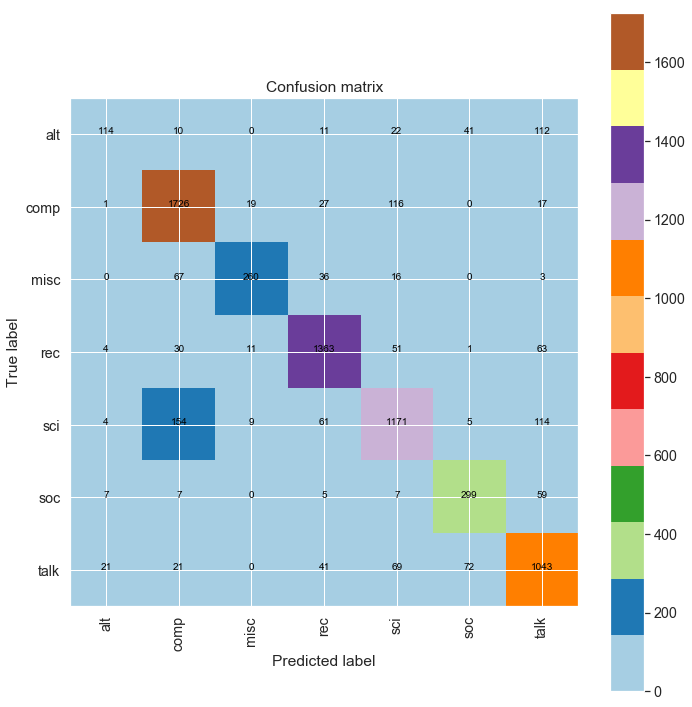

In [89]:
_,_,clf =  classify_and_score(MultinomialNB(alpha = 0.04), vectorised_train_documents, 
                                        vectorised_test_documents, y_train, y_test)

labels = clf.classes_
pred_test = clf.predict(vectorised_test_documents)
print(classification_report(y_test,pred_test,labels = labels))

cnf_matrix = confusion_matrix(y_test, pred_test)
print(plot_confusion_matrix(cnf_matrix, classes = labels))


In [ ]:
get_top_n_words(clf,vectorizer,10)

Заключение.
Наилучшим классфикатором в этой задачи является LinearSVC.
Хотя разрыв между топ-3 классификаторами является достаточно малым.

Также стоит выделить, что в качестве альтернативного лемматизатора был для теста использован gensim lemmatizer, который может выделять однновременно несколько частей речи слов (только 4 если быть точным), но при этом опускает остальные, как результат, пришлось вернуться на ntlk lemmatizer.

In [ ]:
#backup results
#results_df.to_csv("results_df.csv", sep=';', encoding='utf-8',index = False, header = True)

#### Classfication. Without apriory knoweledge.

В этом разделе попробуем классифицировать объекты без знания о принадлежности текстов к какому-либо классу.
Для этого:
- попробуем посмотреть на тексты без знания, об их принадлежности классам.
- сократим размерность (TruncatedSVD)  и попробуем визуализировать структуру данных (T-SNE or UMAP).  
- Попробуем выделить классы при помощи K-means или DBSCAN. (хотелось попробовать использовать HDBSCAN не удалось его установить).
- Провести моделирование тем при помощи LDA и визуализировать топ слов по темам.

#### EDA.
Для того, чтобы оценить как-то текст, без знания меток классов:
- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.
- сколько слов во всех текстах, среднее число слов на 1 текст.
- выделим топ слов по всем текстам и построим их гистограмму.
- построим облако слов. (по мнению CountVectorizer и TfIdfVectorizer).
- построим гистограмму: количество слов - длина слова.

- посчитаем общее количество текстов, построим гистограмму длин текстов, boxplot'ы длин текстов.

In [137]:
print (len(train_texts.data),';',len(test_texts.data))

11314 ; 7532


In [138]:
df_texts = pd.DataFrame(data=train_texts.data.values,columns = ['text'])#, 'text_type'])

df_texts['text_type'] = 'train'

df_texts = df_texts.append(pd.DataFrame(data=test_texts.data.values,columns = ['text']), ignore_index=True,sort=False)

df_texts.fillna(value='test',inplace=True)

df_texts['text_len'] = df_texts.text.str.len()

df_texts['n_words'] = df_texts.text.str.split()

df_texts['n_words'] = df_texts.n_words.str.len()

# count words in train
words_count_train = df_texts[df_texts.text_type == 'train'].n_words.sum()
# count words in test
words_count_test = df_texts[df_texts.text_type == 'test'].n_words.sum()

# count words in train
words_mean_train = df_texts[df_texts.text_type == 'train'].n_words.mean()
# count words in test
words_mean_test = df_texts[df_texts.text_type == 'test'].n_words.mean()

print ("Number of words train/test")
print (words_count_train, words_count_test)
print ()

print ("Mean number of words in train/test text")
print (words_mean_train, words_mean_test)

Number of words train/test
2102451 1320694

Mean number of words in train/test text
185.82738200459607 175.3443972384493


D:\Programs\anaconda3\lib\site-packages\scipy\stats\stats.py:1706: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


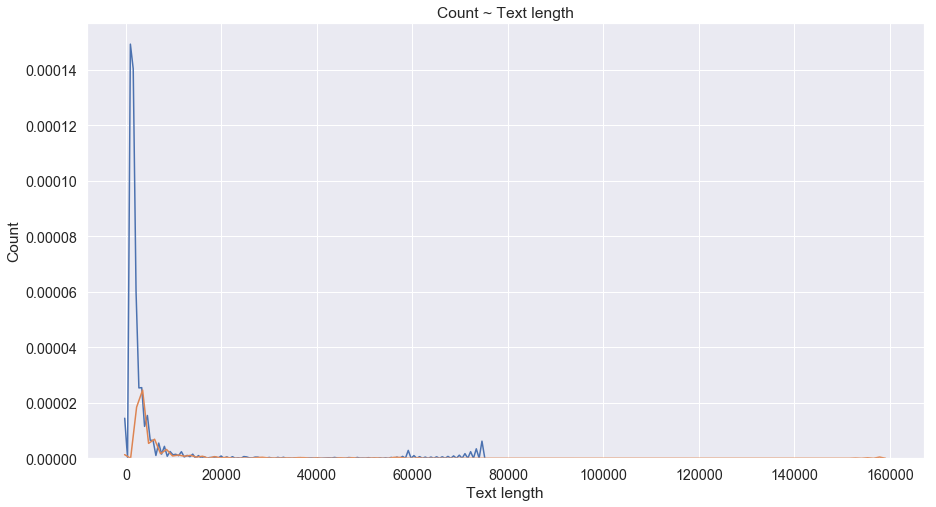

In [90]:
plt.figure(figsize=(15,8))
sns.distplot(df_texts[df_texts.text_type == 'train'].text_len,hist = False)
sns.distplot(df_texts[df_texts.text_type == 'test'].text_len,hist = False)
plt.xlabel('Text length');
plt.ylabel('Count');
plt.title("Count ~ Text length");

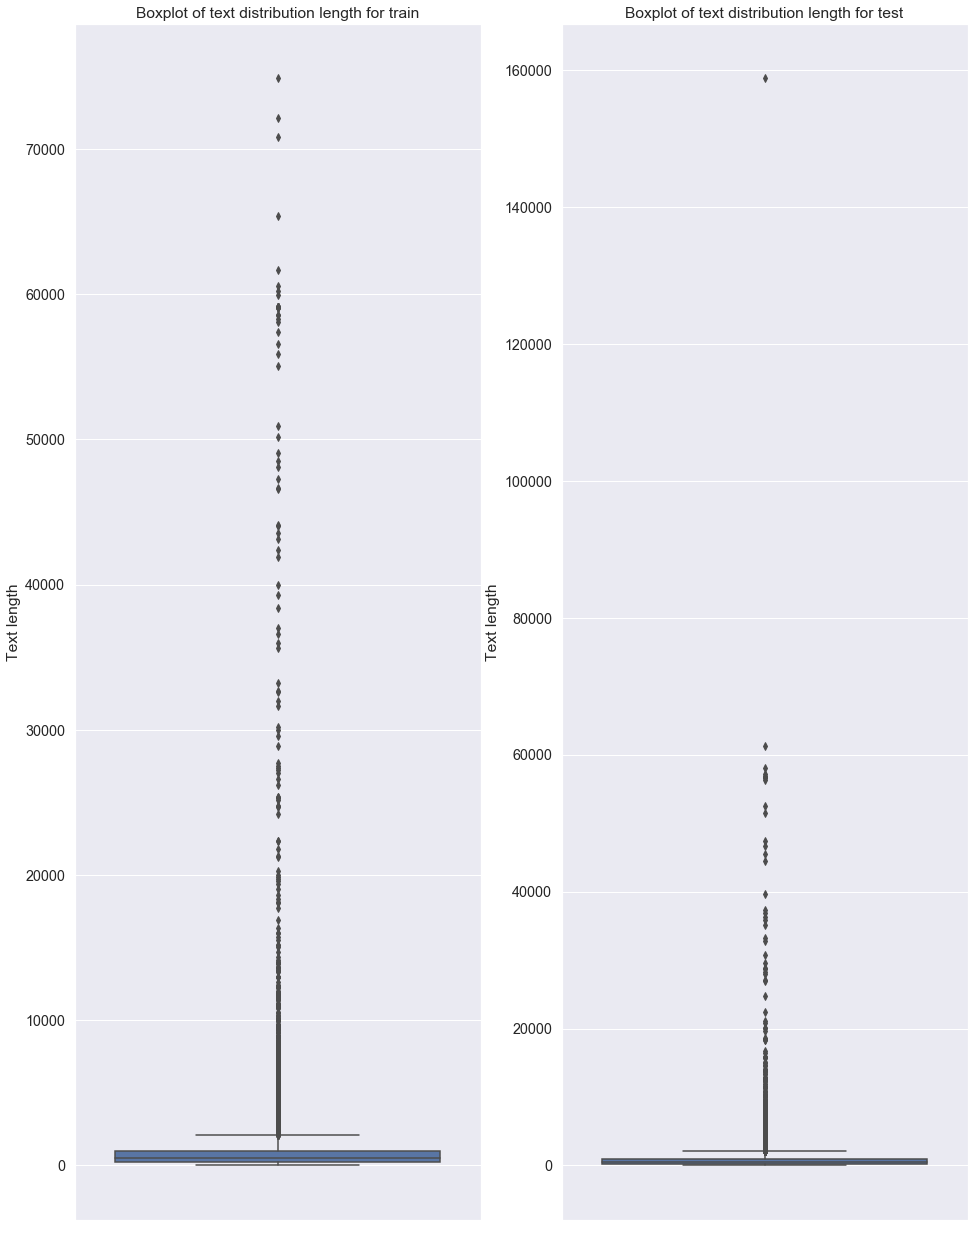

In [1292]:
plt.figure(figsize=(16,22))
plt.subplot(1,2,1)
sns.boxplot(y = df_texts[df_texts.text_type == 'train'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length for train");
plt.subplot(1,2,2)
sns.boxplot(y = df_texts[df_texts.text_type == 'test'].text_len)
plt.ylabel('Text length');
plt.title("Boxplot of text distribution length for test");
plt.show();

Похоже тексты в обучающем датасете чуть более длинные, чем в тестовом.

Также в тестовом датасете есть один достаточно длинный текст.

- Выделим топ-50 слов по всем текстам и построим их график частот.

Здесь помимо использования уже построенного tf-idf словаря хочется попробовать сравнить его с countvectorizer'ом в плане того, какие слова чаще всего встречаются.

In [393]:
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer(tokenizer=tokenize, 
                          stop_words=StopWords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in     vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

In [394]:
start=time.time()
train_top_words = get_top_n_words(train_texts.data, n=150);
test_top_words = get_top_n_words(test_texts.data, n=150);
time.time()-start

D:\Programs\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'shall', 'zsa'] not in stop_words.
  'stop_words.' % sorted(inconsistent))
D:\Programs\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Programs\anaconda3\lib\site-packages\bs4\__init__.py:273: UserWarning: "b'...'" looks like a filename, not markup. You should probably open this file and pass the filehandle into Beautiful Soup.
  ' Beautiful Soup.' % markup)
D:\Programs\anaconda3\lib\site-packages\sklearn\feature_extraction\text.py:300: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['luc', 'mar', 'shall', 'zsa'] not in stop_words.
  'stop_

Wall time: 8min 57s


Some work with tf-idf vocabulary to get most used word(lowest tf-idf score).

In [55]:
train_dict = dict(zip(vectorizer.get_feature_names(), vectorizer.idf_))
train_dict =  dict(sorted(train_dict.items(), key=lambda kv: kv[1]))
# sort in descending order, most freq words first, rare words with big weight in the end

inverse_dict = {}
for k, v in train_dict.items():
    inverse_dict[k] = 1/int(v)

#made only for print
dictlist = []
for key, value in inverse_dict.items():
    temp = [key,value,len(key)]
    dictlist.append(temp)
    
del 

- построим гистограмму: количество слов - длина слова

In [56]:
dictlist_wrds = []
for key, value in inverse_dict.items():
    temp = key
    dictlist_wrds.append(temp)

counts = Counter([len(word) for word in dictlist_wrds])

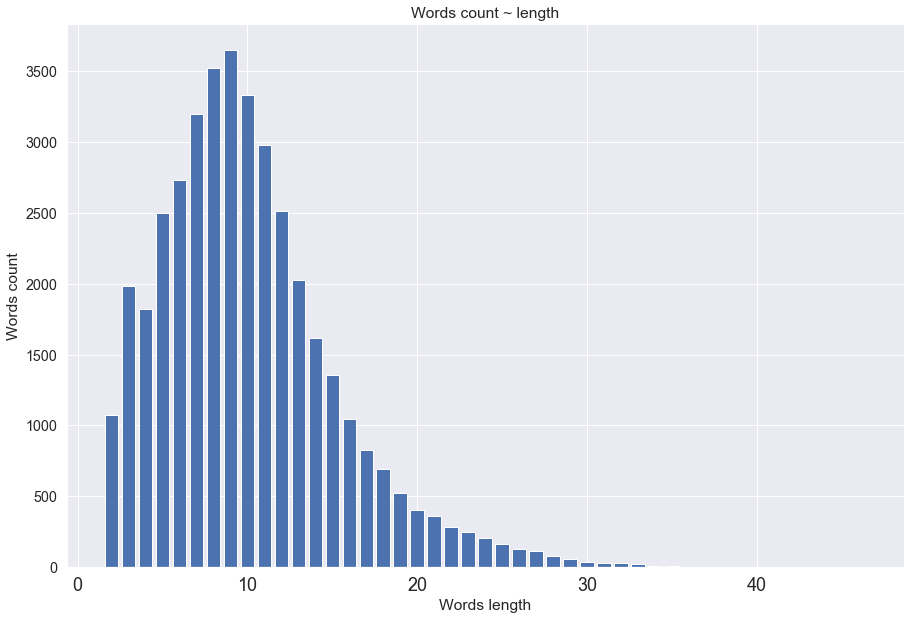

In [63]:
plt.figure(figsize=(15,10))
plt.bar(counts.keys(), counts.values())
plt.xlabel('Words length');
plt.ylabel('Words count');
plt.title("Words count ~ length");
plt.xticks(fontsize = 18)
plt.subplots_adjust(hspace=0.3)

del dictlist_wrds,inverse_dict,train_dict,counts

И гистограммы по словам:

In [151]:
xs_train = [i[0] for i in train_top_words[:50]]
ys_train = [i[1] for i in train_top_words[:50]]

xs_test = [i[0] for i in test_top_words[:50]]
ys_test = [i[1] for i in test_top_words[:50]]

xs_tfidf = [i[0] for i in dictlist[:50]]
ys_tfidf = [i[1] for i in dictlist[:50]]

plt.figure(figsize=(25,20))
plt.subplot(3,1,1)
sns.barplot(x = xs_train, y = ys_train)
plt.ylabel('Words count train');
plt.title("Words frequency histogram");
plt.xticks(rotation=75,fontsize = 18)
plt.subplots_adjust(hspace=0.3)

plt.subplot(3,1,2)
sns.barplot(x = xs_test, y = ys_test)
plt.ylabel('Words count test');
plt.xticks(rotation=75,fontsize = 18)

plt.subplot(3,1,3)
sns.barplot(x = xs_tfidf, y = ys_tfidf)
plt.ylabel('Words count test tfidf');
plt.xticks(rotation=75,fontsize = 18)
plt.show();

del dictlist

NameError: name 'train_top_words' is not defined

Как видно, часть слов совпадает, также стоит отметить, что подход TFIDF нагядно показывает нормировку часто употребимых слов.

##### Words cloud.

Чтобы более наглядно и красиво визуализировать слова попробуем использовать WordClouds.

In [398]:
def create_wc(freq_text, n_words):
    # Initialize wordcloud object
    wc = WordCloud(background_color='white', max_words=n_words,
            stopwords = StopWords,width=1600, height=800)

    # Generate and plot wordcloud
    plt.figure(figsize =[14,7])
    plt.imshow(wc.generate_from_frequencies(frequencies=freq_text))
    plt.axis('off')
    plt.show()

TF-IDF set

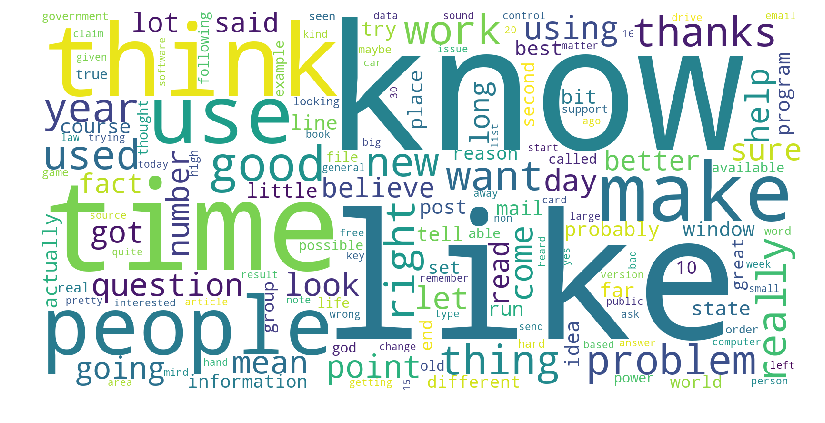

In [399]:
create_wc(inverse_dict,150)
del inverse_dict, train_dict

Count vectorizer train set

In [400]:
train_top_words_test = dict(train_top_words)
test_top_words_test = dict(test_top_words)

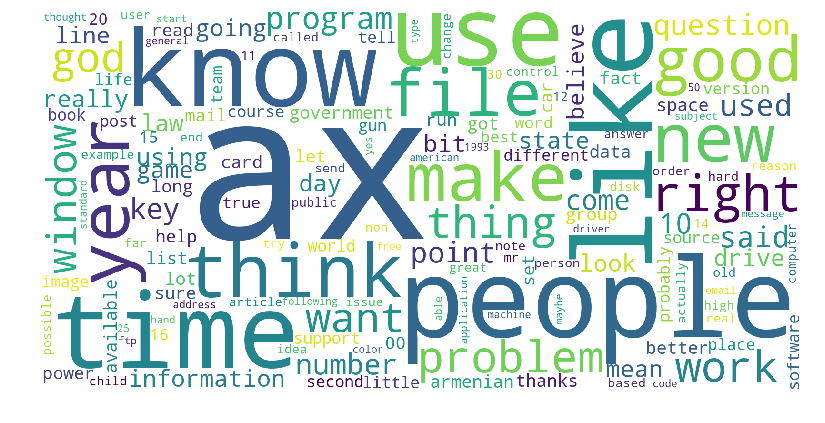

In [401]:
create_wc(train_top_words_test,150)

Count vectorizer test set

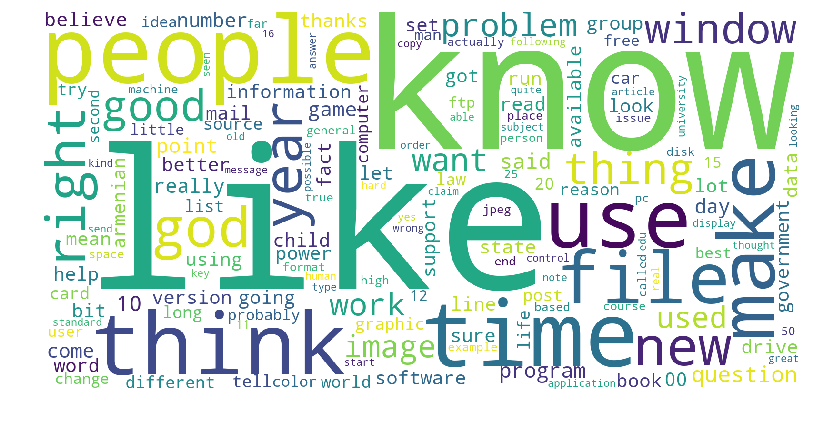

In [402]:
create_wc(test_top_words_test,150)
del train_top_words_test,test_top_words_test

Dimension reduction and visualization:
TruncatedSVD -> T-SNE or UMAP.

Основная идея подобных техник, применяемая в задачах обучения без учителя, состоит в том, чтобы попробовать восстановить и визуализировать структуры данных, которые могут быть скрыты в них.

Так как алгоритмы визуализации (в частности T-SNE работает достаточно небыстро), то перед этим рекомендуется предварительно сократить размерность.

In [69]:
svd = TruncatedSVD(n_components=2000, n_iter=15, random_state=seed)#,algorithm='arpack' can get better result,but time... or 3000

In [70]:
svd.fit(vectorised_train_documents)

TruncatedSVD(algorithm='randomized', n_components=2000, n_iter=15,
       random_state=321, tol=0.0)

In [71]:
print(svd.explained_variance_ratio_.sum())

0.5827538168200641


In [72]:
print(svd.explained_variance_.sum())

0.5777087884643388


In [73]:
%%time
svd_vect_train_documents = svd.transform(vectorised_train_documents)
svd_vect_test_documents = svd.transform(vectorised_test_documents)

C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 3.64 s


In [74]:
svd_vect_train_documents.shape

(10977, 2000)

In [75]:
svd_vect_test_documents.shape

(7290, 2000)

#### T-SNE Test.

In [1330]:
time_start = time.time()
tsne = TSNE(n_components=2, verbose=1, perplexity=50, n_iter=300,learning_rate = 100)
tsne_results = tsne.fit_transform(svd_vect_train_documents)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 10977 samples in 1.989s...
[t-SNE] Computed neighbors for 10977 samples in 714.154s...
[t-SNE] Computed conditional probabilities for sample 1000 / 10977
[t-SNE] Computed conditional probabilities for sample 2000 / 10977
[t-SNE] Computed conditional probabilities for sample 3000 / 10977
[t-SNE] Computed conditional probabilities for sample 4000 / 10977
[t-SNE] Computed conditional probabilities for sample 5000 / 10977
[t-SNE] Computed conditional probabilities for sample 6000 / 10977
[t-SNE] Computed conditional probabilities for sample 7000 / 10977
[t-SNE] Computed conditional probabilities for sample 8000 / 10977
[t-SNE] Computed conditional probabilities for sample 9000 / 10977
[t-SNE] Computed conditional probabilities for sample 10000 / 10977
[t-SNE] Computed conditional probabilities for sample 10977 / 10977
[t-SNE] Mean sigma: 0.284719
[t-SNE] KL divergence after 250 iterations with early exaggeration: 143.325607
[t-SNE]

C:\Anaconda\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


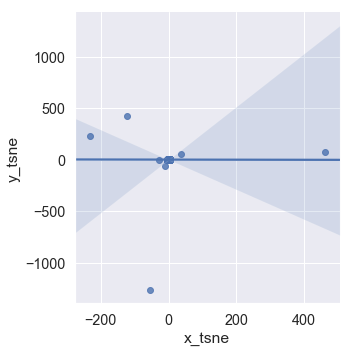

In [1331]:
df_tsne = pd.DataFrame(tsne_results.copy())
df_tsne['x_tsne'] = tsne_results[:,0]
df_tsne['y_tsne'] = tsne_results[:,1]

sns.lmplot(x='x_tsne', y='y_tsne',data = df_tsne)


Похоже имеется несколько кластеров, и по центру несколько пересекаются друг с другом, но сказать что такая картина помогает - сложно.

Возможно для этого датасета такая визуализация является неээфиктивной/либо параметры подобраны неверно.

#### UMAP Tests.

In [1332]:
min_distances = [0.001,0.01,0.1,0.3] #bigger -> scattered
metrics = ['euclidean']#,'minkowski']
n_neighbors = [9]#[7,9,13] 
reducer = umap.UMAP(random_state=seed,n_neighbors=13, min_dist=0.3,metric='minkowski')
reducer

UMAP(a=None, angular_rp_forest=False, b=None, init='spectral',
   learning_rate=1.0, local_connectivity=1.0, metric='minkowski',
   metric_kwds=None, min_dist=0.3, n_components=2, n_epochs=None,
   n_neighbors=13, negative_sample_rate=5, random_state=321,
   repulsion_strength=1.0, set_op_mix_ratio=1.0, spread=1.0,
   target_metric='categorical', target_metric_kwds=None,
   target_n_neighbors=-1, target_weight=0.5, transform_queue_size=4.0,
   transform_seed=42, verbose=False)

SVD Data.

9 euclidean 0.001


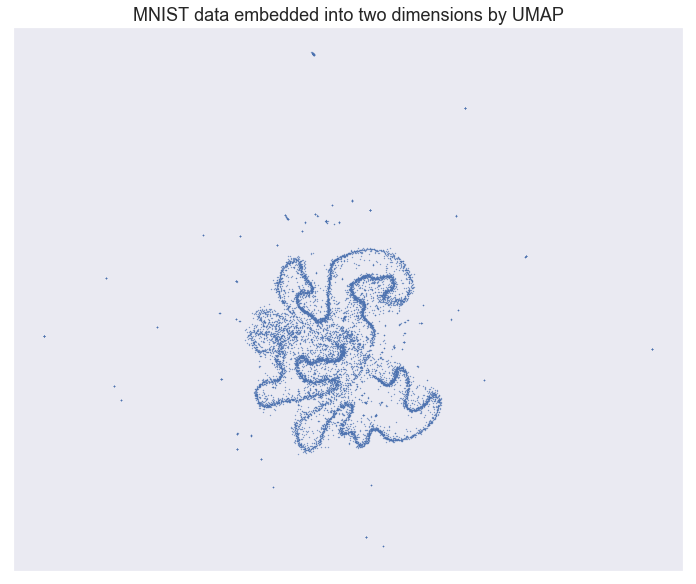

9 euclidean 0.01


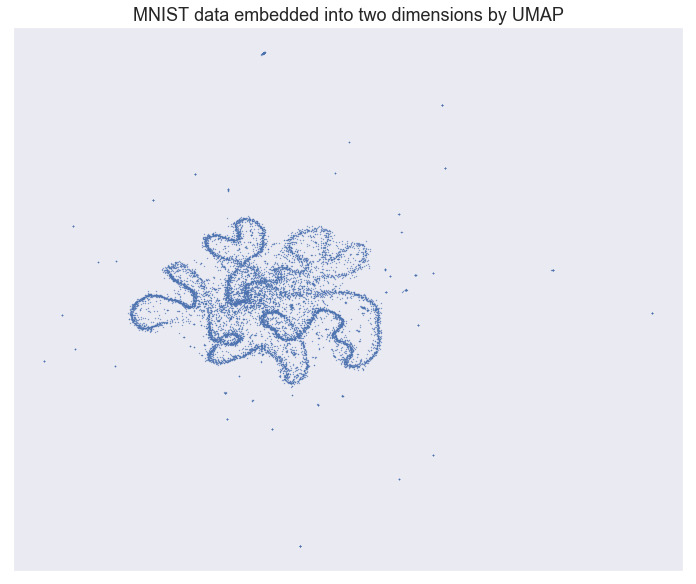

9 euclidean 0.1


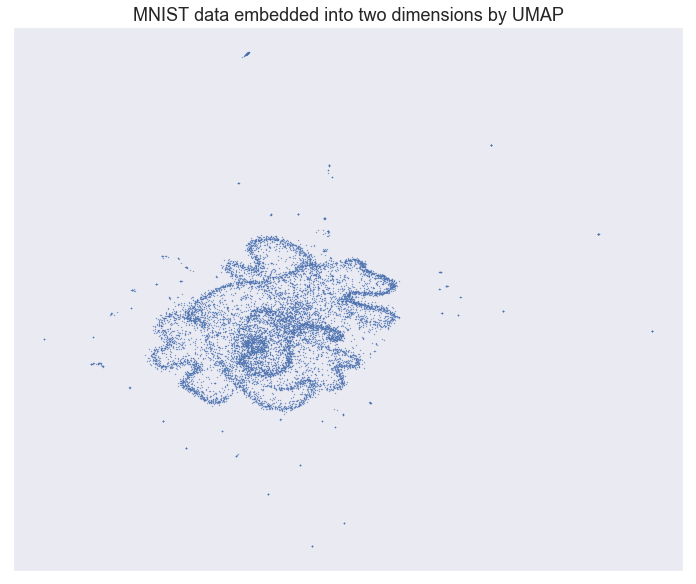

9 euclidean 0.3


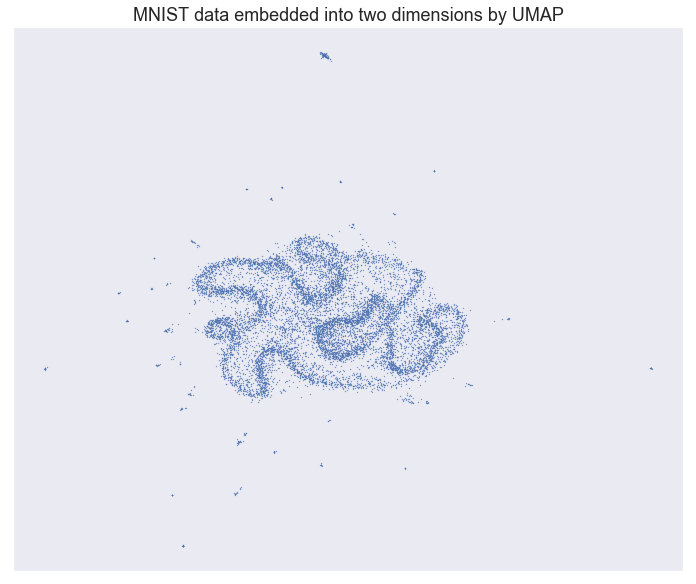

In [114]:
for n_nb in n_neighbors:
    reducer.n_neighbors = n_nb
    for m in metrics:
        reducer.metric = m
        for m_d in min_distances:
            print (n_nb, m, m_d)
            reducer.min_dist = m_d
            embedding = reducer.fit_transform(svd_vect_train_documents)
            fig, ax = plt.subplots(figsize=(12, 10))
            plt.scatter(
            embedding[:, 0], embedding[:, 1],  cmap="Spectral", s=0.1        )#c=mnist.target,
            plt.setp(ax, xticks=[], yticks=[])
            plt.title("SVD data embedded into two dimensions by UMAP", fontsize=18)
            plt.show()
            

TF-IDF Data.
Train Data Example.

9 euclidean 0.001


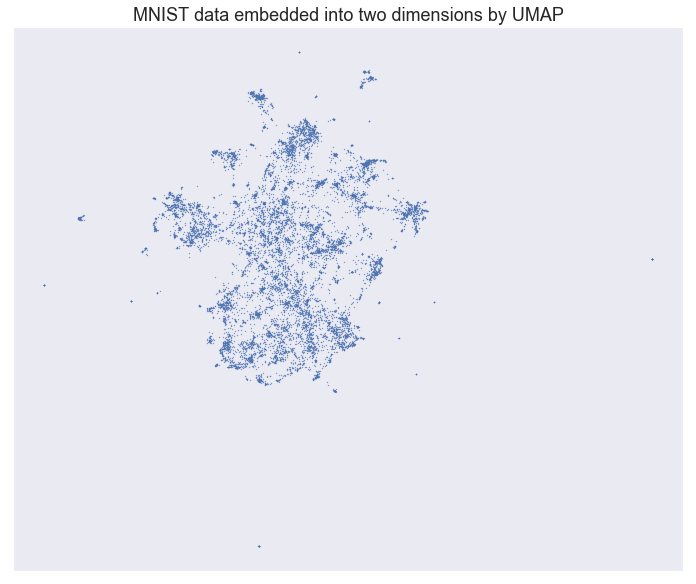

9 euclidean 0.01


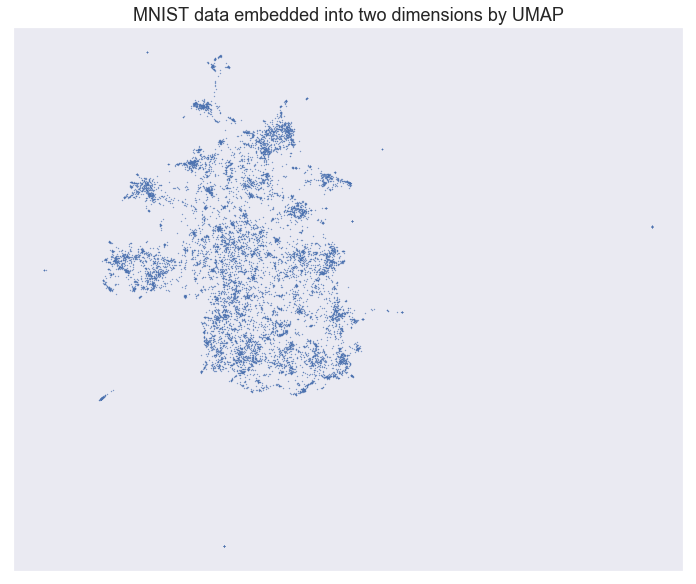

9 euclidean 0.1


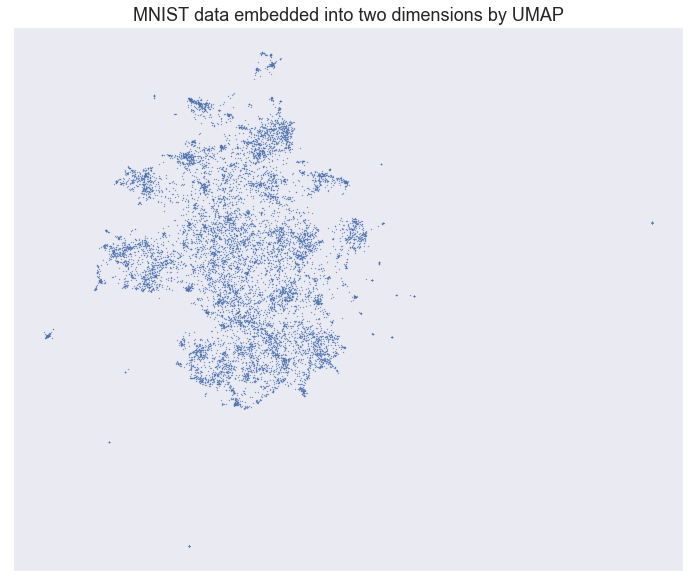

9 euclidean 0.3


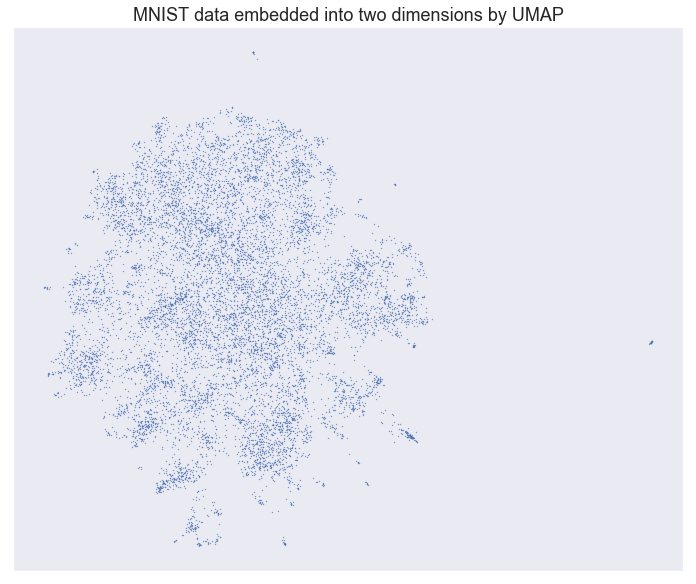

In [1333]:
for n_nb in n_neighbors:
    reducer.n_neighbors = n_nb
    for m in metrics:
        reducer.metric = m
        for m_d in min_distances:
            print (n_nb, m, m_d)
            reducer.min_dist = m_d
            embedding = reducer.fit_transform(vectorised_train_documents)
            fig, ax = plt.subplots(figsize=(12, 10))
            plt.scatter(
            embedding[:, 0], embedding[:, 1],  cmap="Spectral", s=0.1        )#c=mnist.target,
            plt.setp(ax, xticks=[], yticks=[])
            plt.title("TfIDF train data embedded into two dimensions by UMAP", fontsize=18)
            plt.show()
            

На примере графика с данными от TFIDF c параметрам - количество соседеней -  9, метрика - euclidean, минимальная дистанция -  0.01/0.001, можно различить несколько сгруппированных групп точек.

Что, в свою очередь, может говорить о наличии нескольких тем в данных.

#### Kmeans and DBSCAN.

В первую очередь, попробуем использовать алгоритм K-Means для кластеризации данных.

Т.к. при кластеризации осуществляется вычисление расстояний между объектами, то лучше будет выровнять веса полученные при помощи TFIDF.

In [76]:
ss = StandardScaler(with_mean=False)

ss.fit(vectorised_train_documents)

vectorised_train_documents_scaled = ss.transform(vectorised_train_documents)
vectorised_test_documents_scaled = ss.transform(vectorised_test_documents)

Зададим параметры.

In [100]:
k_clusters = 3 # Number of Centroids, correspond to amount high level topics
model = KMeans(n_clusters=k_clusters, max_iter=150, 
               n_init=14, n_jobs=-1,
               init = 'k-means++',precompute_distances = 'auto',random_state =seed)

Т.к. Kmeans чувствителен к параметру - количество кластеров, попробуем его подобрать по метрике silhouette_score.

In [79]:
clust_n = [3 ,4 ,5 ,6 ,7 ,8 ,9 ,10 ,11 ,13 ,15 ,25 ,50 ,100]
    
res_list = []
for cln in clust_n:
    model.n_clusters = cln
    if cln ==5:
        break
    model.fit(vectorised_train_documents_scaled)
    sc = silhouette_score(vectorised_train_documents_scaled, model.labels_,metric='euclidean', random_state=seed)
    print (cln , sc)
    temp = [cln,sc]
    res_list.append(temp)


    
res_list

3 0.311743353233248


[[3, 0.311743353233248]]

In [101]:
model.n_clusters = k_clusters = 3
model.fit_predict(vectorised_train_documents_scaled)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=150,
    n_clusters=3, n_init=14, n_jobs=-1, precompute_distances='auto',
    random_state=321, tol=0.0001, verbose=0)

Для оценки параметров кластеризации воспользуемся функцией, которая будет вычислять несколько метрик сразу.

In [102]:
def bench_k_means(estimator, name, data, labels,sample_size):
    print(89 * '_')
    print('init\tinertia\t\thomo\tcompl\tv-meas\tARI\tAMI\tsilhouette')

    print('%-5s\t%i\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
          % (name, estimator.inertia_,
             homogeneity_score(labels, estimator.labels_),
             completeness_score(labels, estimator.labels_),
             v_measure_score(labels, estimator.labels_),
             adjusted_rand_score(labels, estimator.labels_),
             adjusted_mutual_info_score(labels,  estimator.labels_,average_method='arithmetic'),
             silhouette_score(data, estimator.labels_,metric='euclidean',random_state=seed)#, sample_size=sample_size)
            )
         )

In [103]:
bench_k_means(model, "kmeans" , vectorised_train_documents_scaled, y_train, k_clusters)

_________________________________________________________________________________________
init	inertia		homo	compl	v-meas	ARI	AMI	silhouette
kmeans	427365702	0.001	0.132	0.002	-0.000	0.002	0.312


In [105]:
print("Top terms per cluster:")
order_centroids = model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(k_clusters):
    print("Cluster %d:" % i),
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind]),
    print


Top terms per cluster:
Cluster 0:
 1z6e
 7ez
 7ey
 3v9f0
 ei0l
 0q ax ax
 0q ax
 gk wt
 1eq
 7klj
Cluster 1:
 like
 know
 think
 people
 time
 make
 use
 good
 way
 thing
Cluster 2:
 leonard ramsden
 ramsden
 305 page memoir
 305 page
 indianapolis 1926 305
 like leonard ramsden
 memoir armenian officer
 indianapolis 1926
 company indianapolis
 company indianapolis 1926


In [1410]:
transf = model.transform(vectorised_train_documents_scaled)

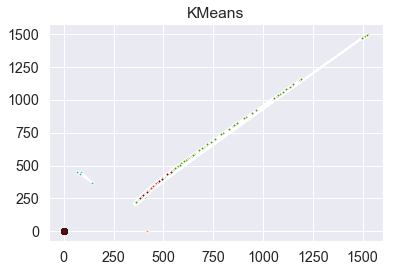

In [1411]:
k_means_labels = model.labels_
k_means_cluster_centers = model.cluster_centers_

X = transf
colors = ['#4EACC5', '#FF9C34', '#4E9A06','#ce3d2b','#800000','#ce3d2b','#800000']

plt.figure()
for k, col in zip(range(k_clusters), colors):
    my_members = k_means_labels == k
    cluster_center = k_means_cluster_centers[k]
    plt.plot(X[my_members, 0], X[my_members, 1], 'w',
            markerfacecolor=col, marker='.')
    plt.plot(cluster_center[0], cluster_center[1], 'o', markerfacecolor=col,
            markeredgecolor='k', markersize=6)
plt.title('KMeans')    
plt.grid(True)
plt.show()

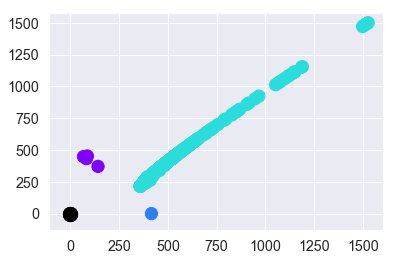

In [1389]:
plt.scatter(transf[:,0],transf[:,1], c=k_means_labels, cmap='rainbow',s=150)

plt.scatter(k_means_cluster_centers[:, 0], k_means_cluster_centers[:, 1], c='black', s=200, alpha=0.5);

#### DBSCAN.

In [107]:
clusterer = DBSCAN(n_jobs=-1, eps=0.7, metric = 'cosine', min_samples=17)#cosine

#eps=0.7, metric='euclidean', min_samples=5, 

In [108]:
clusterer
# tune eps, leaf_size, metric?
# nope,because brute only, in case of sparse matrix

DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=17, n_jobs=-1, p=None)

In [106]:
eps_s = [0.1,0.3,0.5,0.7,0.9,1.5,3,7]
min_smples = [10,17,20,30]
res_list_kmeans = []

for ms in min_smples:
    clusterer.min_samples = ms
    if ms == 17: break
    for eps in eps_s:
        clusterer.eps = eps
        clusterer.fit(vectorised_train_documents_scaled)
        labels = clusterer.labels_
        n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
        if n_clusters_ > 1:
            sc = silhouette_score(vectorised_train_documents_scaled, labels,metric='euclidean',random_state=seed)
            temp = [ms, eps, sc]
            res_list_kmeans.append(temp)
        else:
            temp = [ms,eps,'false']
            res_list_kmeans.append(temp)

        

res_list_kmeans

10 0.3 0.002722635469484299
10 0.5 0.002594671828463732
10 0.7 -0.006774320493322059


[[10, 0.1, 'false'],
 [10, 0.3, 0.002722635469484299],
 [10, 0.5, 0.002594671828463732],
 [10, 0.7, -0.006774320493322059],
 [10, 0.9, 'false'],
 [10, 1.5, 'false'],
 [10, 3, 'false'],
 [10, 7, 'false']]

Здесь, результаты схожие с KMeans.

In [1400]:
clusterer.min_samples = 17
clusterer.eps = 0.7

clusterer.fit(vectorised_train_documents)


C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1200: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1202: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tp = clock()-t0
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1217: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  t0 = clock()
C:\Anaconda\lib\site-packages\IPython\core\magics\execution.py:1219: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  tc = clock()-t0
C:\Anaconda\lib\site-packages\IPython\utils\ti

Wall time: 7.48 s


DBSCAN(algorithm='auto', eps=0.7, leaf_size=30, metric='cosine',
    metric_params=None, min_samples=17, n_jobs=-1, p=None)

In [1401]:
labels = clusterer.labels_
labels_true = y_train

n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

In [1412]:
print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("Homogeneity: %0.3f" % homogeneity_score(labels_true, labels))
print("Completeness: %0.3f" % completeness_score(labels_true, labels))
print("V-measure: %0.3f" % v_measure_score(labels_true, labels))
print("Adjusted Rand Index: %0.3f"
      % adjusted_rand_score(labels_true, labels))
print("Adjusted Mutual Information: %0.3f"
      % adjusted_mutual_info_score(labels_true, labels,average_method='arithmetic'))
print("Silhouette Coefficient: %0.3f"
      % silhouette_score(vectorised_train_documents_scaled, labels,random_state=seed))

Estimated number of clusters: 4
Estimated number of noise points: 10835
Homogeneity: 0.013
Completeness: 0.267
V-measure: 0.025
Adjusted Rand Index: 0.000
Adjusted Mutual Information: 0.023
Silhouette Coefficient: -0.124


In [1413]:
core_samples_mask = np.zeros_like(clusterer.labels_, dtype=bool)
core_samples_mask[clusterer.core_sample_indices_] = True

unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

#### Topic modelling.

#### LDA from Gensim.

Основной идеей тематического моделирования является попытка определить по набору слов, к какой теме они относятся.

Основными понятиями в данной области является тема - набор слов(н-грам) и документ, описывающий распределение документов над темами.

Проинизиализурем модель LDA из пакета Gensim..

In [83]:
num_topics=7 
passes=20

corpus = matutils.Sparse2Corpus(vectorised_train_documents.T)

vocab = vectorizer.get_feature_names()

dictionary = Dictionary.from_corpus(corpus,
                                    dict([(i, s) for i, s in enumerate(vocab)]))


lda = LdaModel(corpus, num_topics=num_topics,
         passes=passes,
         id2word=dict([(i, s) for i, s in enumerate(vocab)]))

UsageError: Cell magic `%%time;` not found.


In [57]:
def print_topics(lda, vocab, n=10):
    """ Print the top words for each topic. """
    topics = lda.print_topics(num_topics=-1, num_words=n)
    for topic in topics:
        print(topic)

Выведем топ слов по заданному количеству топиков.

In [58]:
print_topics(lda, vocab, 7)

(0, '0.000*"sig" + 0.000*"cheat hillary" + 0.000*"cell church" + 0.000*"yo" + 0.000*"\\\\" + 0.000*"hillary" + 0.000*"yo yo"')
(1, '0.002*"people" + 0.002*"think" + 0.002*"like" + 0.002*"time" + 0.002*"know" + 0.002*"year" + 0.001*"say"')
(2, '0.000*"humanist" + 0.000*"chop" + 0.000*"greenberg" + 0.000*"hee" + 0.000*"timmons" + 0.000*"hank greenberg" + 0.000*"bake timmons"')
(3, '0.003*"window" + 0.003*"thanks" + 0.002*"file" + 0.002*"use" + 0.002*"card" + 0.002*"drive" + 0.002*"know"')
(4, '0.000*"chris" + 0.000*"ames" + 0.000*"shafer" + 0.000*"mary shafer" + 0.000*"nasa ames" + 0.000*"dryden" + 0.000*"shafer nasa"')


При помощи pyLDAvis визуализируем данные:

In [59]:
pyLDAvis.enable_notebook()
pyLDAvis.gensim.prepare(lda, corpus, dictionary)

C:\Anaconda\lib\site-packages\pyLDAvis\_prepare.py:257: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  return pd.concat([default_term_info] + list(topic_dfs))


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.136278 -0.070853       1        1  64.752708
3      0.039996  0.139880       2        1  25.177982
4     -0.061514 -0.023526       3        1   3.547195
2     -0.060712 -0.023231       4        1   3.491707
0     -0.054048 -0.022269       5        1   3.030416, topic_info=      Category        Freq                Term       Total  loglift  logprob
term                                                                        
38439  Default   59.000000              window   59.000000  30.0000  30.0000
34917  Default   71.000000              thanks   71.000000  29.0000  29.0000
14218  Default   45.000000                file   45.000000  28.0000  28.0000
7455   Default   40.000000                card   40.000000  27.0000  27.0000
11978  Default   48.000000               drive   48.000000  26.0000  26.0000
21718  Default   46.000000                mail   46.000000  25.0000  25.0000
36839  Default   79.000000                 use   79.000000  24.0000  24.0000
32667  Default   31.000000            software   31.000000  23.0000  23.0000
25734  Default   27.000000                  pc   27.000000  22.0000  22.0000
27863  Default   44.000000             program   44.000000  21.0000  21.0000
17056  Default   32.000000                  hi   32.000000  20.0000  20.0000
27648  Default   71.000000             problem   71.000000  19.0000  19.0000
3563   Default   28.000000             advance   28.000000  18.0000  18.0000
16165  Default   23.000000             graphic   23.000000  17.0000  17.0000
37109  Default   47.000000               using   47.000000  16.0000  16.0000
23212  Default   25.000000             monitor   25.000000  15.0000  15.0000
16947  Default   49.000000                help   49.000000  14.0000  14.0000
34918  Default   22.000000      thanks advance   22.000000  13.0000  13.0000
12035  Default   34.000000              driver   34.000000  12.0000  12.0000
14959  Default   21.000000                 ftp   21.000000  11.0000  11.0000
12575  Default   30.000000               email   30.000000  10.0000  10.0000
11565  Default   24.000000                disk   24.000000   9.0000   9.0000
21605  Default   23.000000                 mac   23.000000   8.0000   8.0000
38748  Default   68.000000                work   68.000000   7.0000   7.0000
21314  Default   40.000000             looking   40.000000   6.0000   6.0000
37516  Default   23.000000               video   23.000000   5.0000   5.0000
19771  Default  113.000000                know  113.000000   4.0000   4.0000
8663   Default   23.000000               color   23.000000   3.0000   3.0000
37428  Default   30.000000             version   30.000000   2.0000   2.0000
21640  Default   29.000000             machine   29.000000   1.0000   1.0000
...        ...         ...                 ...         ...      ...      ...
11911   Topic5    0.495693            dr speed    0.909652   2.8894  -8.3915
3001    Topic5    0.665019                  \\    1.262506   2.8554  -8.0977
2162    Topic5    0.432289             517 355    0.845461   2.8257  -8.5284
22396   Topic5    0.432289  mcwilliams 517 355    0.845461   2.8257  -8.5284
22395   Topic5    0.432289      mcwilliams 517    0.845461   2.8257  -8.5284
35696   Topic5    0.432289       tommy mac tom    0.845461   2.8257  -8.5284
35688   Topic5    0.432289  tom mcwilliams 517    0.845461   2.8257  -8.5284
22394   Topic5    0.432289          mcwilliams    0.845461   2.8257  -8.5284
2163    Topic5    0.432289        517 355 2178    0.845461   2.8257  -8.5284
2882    Topic5    0.432289                9591    0.845461   2.8257  -8.5284
2883    Topic5    0.432289             9591 hm    0.845461   2.8257  -8.5284
2884    Topic5    0.432289          9591 hm \\    0.845461   2.8257  -8.5284
1688    Topic5    0.432289            336 9591    0.845461   2.8257  -8.5284
1689    Topic5    0.432289         33

Как видно, наблюдается несколько топиков, из которых можно выделить:


Заключение:

- про схожесть топика с топом слов в tf idf.
- logistic regression?

#### difference between clustering, dimension reduction and topic modeling.

Кластеризация - 

Сокращение размерности - 

Тематическое моделирование - процесс одновременной кластеризации текстов и слов по одному и тому же множеству кластеров, называемых темами. 

Обычно выполняется нечёткая кластеризация, когда документ/слово может принадлежать нескольким темам.

По сути, мы пытаемся по tf-idf скору построить вероятностное распределение на множестве тем.

!!! to read !!!

- http://www.machinelearning.ru/wiki/images/f/f7/VMK_NLP_TM.pdf

- http://www.ispras.ru/proceedings/docs/2012/23/isp_23_2012_215.pdf

- https://iksinc.online/2016/05/16/topic-modeling-and-document-clustering-whats-the-difference/

- https://people.cs.umass.edu/~brenocon/inlp2014/lectures/22-tm.pdf

In [143]:
print test

SyntaxError: Missing parentheses in call to 'print'. Did you mean print(test)? (<ipython-input-143-f95b3ffdade0>, line 1)

#### Appendix

Функция удаления пустых строк в numpy sparce matrix.

In [ ]:
def remove_zero_tf_idf(Xtr, min_tfidf=0.04):
    D = Xtr.toarray() # convert to dense if you want
    D = Xtr
    D[D < min_tfidf] = 0
    tfidf_means = np.mean(D, axis=0) # find features that are 0 in all documents
    D = np.delete(D, np.where(tfidf_means == 0)[0], axis=1) # delete them from the matrix
    return D

In [ ]:
def show_most_informative_features(vectorizer, clf, n=20):
    aa = []
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t% 15s\t\t%.4f\t% 15s" % (coef_1, fn_1, coef_2, fn_2))
        aa.append(fn_1)
        
    #return aa

In [ ]:
show_most_informative_features(vectorizer, clf, 10)

from word cloud tests

In [95]:
'''indices = np.argsort(vectorizer.idf_)[::-1] #
features = vectorizer.get_feature_names()
top_n = 15
top_features = [features[i] for i in indices[:top_n]]
print (top_features)''';

In [96]:
'''from collections import defaultdict

features_by_gram = defaultdict(list)
for f, w in zip(vectorizer.get_feature_names(), vectorizer.idf_):
    features_by_gram[len(f.split(' '))].append((f, w))

top_n = 15

for gram, features in features_by_gram.items():
    top_features = sorted(features, key=lambda x: x[1], reverse=True)[:top_n]
    top_features = [f[0] for f in top_features]
    print ('{}-gram top:'.format(gram), top_features)''';

 The higher the numerical weight value, the rarer the term. The smaller the weight, the more common the term.

In [97]:
'''#test block
indices = np.argsort(vectorizer.idf_)[::-1] # The inverse document frequency (IDF) vector, -1 if we want biggest first tf-idf weight
features = vectorizer.get_feature_names() #



np.sort(vectorizer.idf_)[::1]

indices

features[1604549]

#voc_dict = dict(zip(features,indices))
voc_dict = [features[i] for i in indices]
#voc_dict''';

In [98]:
'''from itertools import islice

def take(n, iterable):
    #"Return first n items of the iterable as a list"
    return dict(islice(iterable, n))

n_items = take(5, gg.items())

n_items''';

GENSIM LDA.

In [139]:
def gensim_output(modelfile, corpusfile, dictionaryfile): 
    """Displaying gensim topic models"""
    ## Load files from "gensim_modeling"
    corpus = corpora.MmCorpus(corpusfile)
    dictionary = corpora.Dictionary.load(dictionaryfile) # for pyLDAvis
    myldamodel = models.ldamodel.LdaModel.load(modelfile)    

    ## Interactive visualisation
    import pyLDAvis.gensim
    vis = pyLDAvis.gensim.prepare(myldamodel, corpus, dictionary)
    pyLDAvis.display(vis)

In [140]:
#gensim_output(lda, vec, dictionary)

In [144]:
#pyLDAvis.gensim.prepare(lda, corpus, dictionary) #working

In [142]:
#pyLDAvis.sklearn.prepare(lda, corpus, vectorizer)

SVC different kernels test

In [ ]:

'''
#C_values = [ 0.05, 0.1, 0.15 ,0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 1.0, 2.0, 5.0, 10.0, 20.0]
C_values_reduced = [0.001, 0.01, 0.5]

for c in tqdm(C_values_reduced):
    f_el = "SVC_poly"
    svc_poly.C = c
    s_el,t_el,_ = classify_and_score(svc_poly, vectorised_train_documents, vectorised_test_documents, y_train, y_test)
    f0_el = "C = " + str(c)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)'''


'''
kernels = ['rbf','sigmoid']
C_values_reduced = [0.001, 0.01, 0.5, 1.0, 5.0]

for kern in tqdm(kernels):
    svc_k.kernel = kern
    for c in tqdm(C_values_reduced):
        svc_k.C = c
        f_el = "SVC_" + kern
        s_el,t_el,_ = classify_and_score(svc_k,vectorised_train_documents, vectorised_test_documents, y_train, y_test)
        f0_el = "C = " + str(c) + " Kernel = " + kern

        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)'''

GaussianNB не использовался, т.к. на вход этому алгоритму требуется dense, а не sparce-матрица.
При выполнении преобразования todense()/toarray() потребление памяти существенно возрастает и приводит к тому, что массив не помещяется в память.

In [72]:
"""clf = GaussianNB()
clf.fit(vectorised_train_documents.toarray(), y_train)
pred = clf.predict(vectorised_test_documents.toarray())
f1_score(y_test, pred, average='micro')""";

Elastic Net sgd.

In [70]:
#attempt of elastic net

'''alphas = [0.0001, 0.001, 0.01, 0.1, 0.5, 1, 3, 5]
l1_ratios = [0.0001, 0.001, 0.01, 0.1, 0.3, 0.5, 0.7, 0.9]

for alp in tqdm(alphas):
    sgd_clf.alpha = alp
    for l1 in tqdm(l1_ratios):
        f_el = "SGD"
        sgd_clf.l1_ratio = l1
        s_el,t_el,_ = classify_and_score(sgd_clf, vectorised_train_documents, 
                                         vectorised_test_documents, y_train, y_test)
        f0_el = "alpha = " + str(alp) + " l1_ratio = " + str(l1)
        results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                        'Test_score':t_el, 'parameters':f0_el},ignore_index=True)''';
# compare hinge loss == linear SVM
# compare other different kernels

- BernoulliNB

In [280]:
for alph in tqdm(alphas):
    f_el = "BernoulliNB"
    s_el,t_el,_ = classify_and_score(BernoulliNB(alpha=alph), vectorised_train_documents, 
                           vectorised_test_documents, y_train, y_test)
    f0_el = "alpha = " + str(alph)

    results_df = results_df.append({'Algorithm':f_el, 'Train_score':s_el,
                                    'Test_score':t_el, 'parameters':f0_el},ignore_index=True)

100%|██████████████████████████████████████████| 51/51 [00:04<00:00, 12.33it/s]


In [116]:
def confusion_matrix(act_labels, pred_labels):
    uniqueLabels = list(set(act_labels))
    clusters = list(set(pred_labels))
    cm = [[0 for i in range(len(clusters))] for i in range(len(uniqueLabels))]
    for i, act_label in enumerate(uniqueLabels):
        for j, pred_label in enumerate(pred_labels):
            if act_labels[j] == act_label:
                cm[i][pred_label] = cm[i][pred_label] + 1
    return cm


cnf_matrix = confusion_matrix(y_train, model.labels_)
print('\n'.join([''.join(['{:4}'.format(item) for item in row])
      for row in cnf_matrix]))

  87  70 227
  95  71 240
  62  52 180
 292 242 702
 444 3981057
 364 301 870
 316 315 905
